In [23]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#o arquivo vem sem o ano, então adicionamos um so para ter a info 
def colocarAno(x):
    return pd.datetime.strptime('201'+x, '%Y-%m')
#header para ter o cabeçalho / squeeze para dividir em mais colunas
serieVendas = pd.read_excel('vendas por mes.xlsx', header=0, parse_dates=[0],index_col=0)
serieVendas.head()


,mês
data,
2012-01-01,585
2012-02-01,395
2012-03-01,468
2012-04-01,687
2012-05-01,613


Text(0, 0.5, 'Venda mensal')

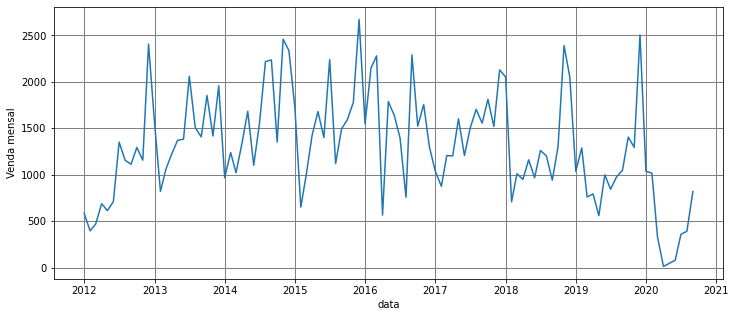

In [24]:
plt.figure(figsize=(12,5))
plt.plot(serieVendas)
plt.grid(color='grey', linestyle='-', linewidth=1)
plt.xlabel('data')
plt.ylabel('Venda mensal')

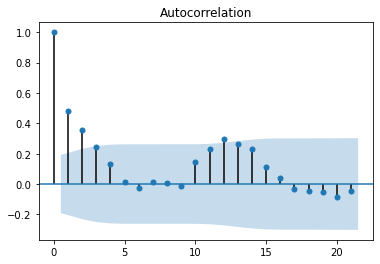

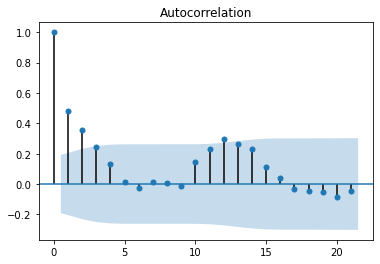

In [25]:
serieVendas = pd.read_excel('vendas por mes.xlsx', header=0, parse_dates=[0],index_col=0)
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(serieVendas)

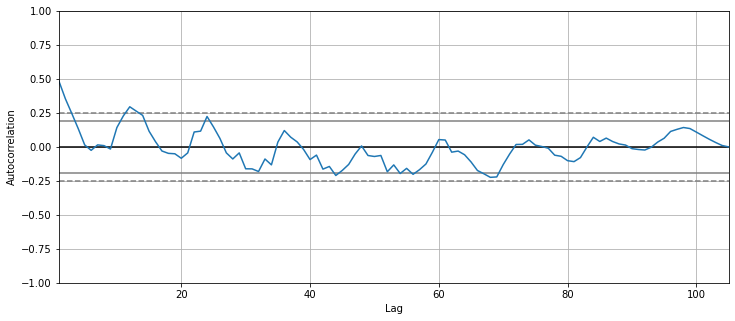

In [26]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(serieVendas)

In [27]:
from statsmodels.tsa.arima_model import ARIMA

C:\Users\lindo e linda\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\lindo e linda\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                             ARIMA Model Results                              
Dep. Variable:                  D.mês   No. Observations:                  104
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -796.906
Method:                       css-mle   S.D. of innovations            513.788
Date:                Wed, 14 Oct 2020   AIC                           1607.811
Time:                        14:00:58   BIC                           1626.322
Sample:                    02-01-2012   HQIC                          1615.311
                         - 09-01-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.2332     23.155     -0.010      0.992     -45.617      45.150
ar.L1.D.mês    -0.5097      0.097     -5.229      0.000      -0.701      -0.319
ar.L2.D.mês    -0.2892      0.109     -2.653    

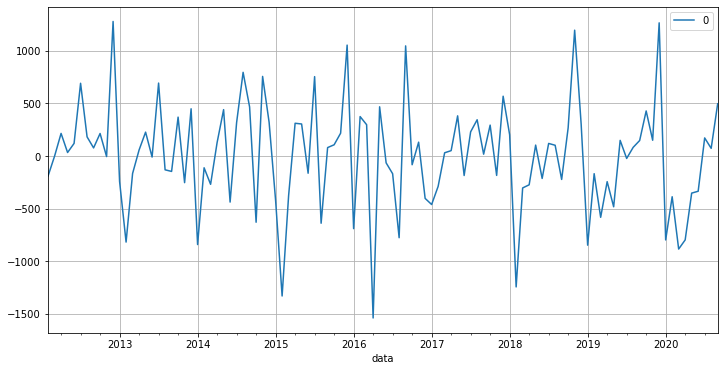

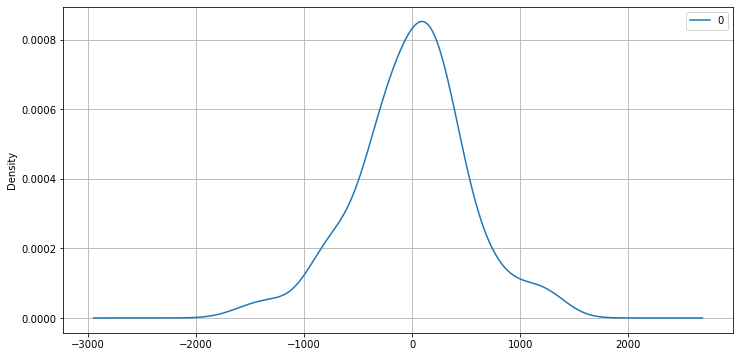

In [34]:
# fit do modelo
modelo = ARIMA(serieVendas, order=(5,1,0))
modelo_fitado = modelo.fit(disp=0)
print(modelo_fitado.summary())

# plotar os erros residuais
residuais = pd.DataFrame(modelo_fitado.resid)

residuais.plot(grid = True, figsize=(12,6))

residuais.plot(kind='kde',grid = True, figsize=(12,6))

print(residuais.describe())

previsto = 1538.322097, esperado = 1812.000000
previsto = 1699.266705, esperado = 1518.000000
previsto = 1615.527500, esperado = 2128.000000
previsto = 1841.992145, esperado = 2053.000000
previsto = 1931.662939, esperado = 708.000000
previsto = 1541.845916, esperado = 1010.000000
previsto = 1434.954769, esperado = 949.000000
previsto = 1167.630800, esperado = 1160.000000
previsto = 1206.527707, esperado = 967.000000
previsto = 1088.160630, esperado = 1260.000000
previsto = 1111.224252, esperado = 1203.000000
previsto = 1156.350098, esperado = 940.000000
previsto = 1084.869783, esperado = 1305.000000
previsto = 1200.372172, esperado = 2390.000000
previsto = 1642.906655, esperado = 2050.000000
previsto = 1786.383858, esperado = 1036.000000
previsto = 1525.340416, esperado = 1288.000000
previsto = 1550.803848, esperado = 760.000000
previsto = 1194.614029, esperado = 793.000000
previsto = 1153.380449, esperado = 559.000000
previsto = 863.267274, esperado = 999.000000
previsto = 885.053073,

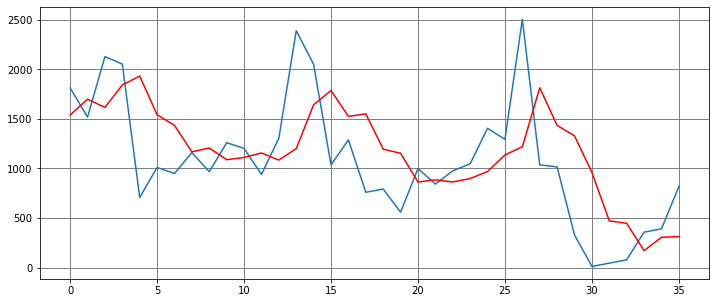

In [37]:
from sklearn.metrics import mean_squared_error
import numpy as np

X = serieVendas.values
tamanho = int(len(X) * 0.66)
train, test = X[0:tamanho], X[tamanho:]
historico = [x for x in train]
predicoes = list()
for t in range(len(test)):
    model = ARIMA(historico, order=(5,1,0))
    model_fit = model.fit(disp=0)
    saida = model_fit.forecast()
    aux = saida[0]
    predicoes.append(aux)
    aux2 = test[t]
    historico.append(aux2)
    print('previsto = %f, esperado = %f' % (aux, aux2))
erro = np.sqrt(mean_squared_error(test, predicoes))
print('Teste RMSE: %.3f' % erro)

# plot
plt.figure(figsize=(12,5))

plt.grid(color='grey', linestyle='-', linewidth=1)
plt.plot(test)
plt.plot(predicoes, color='red')


In [42]:
import warnings
warnings.filterwarnings("ignore")

In [47]:
def evaluate_arima_model(X, arima_order):
    tamanho = int(len(X) * 0.66)
    train, test = X[0:tamanho], X[tamanho:]
    historico = [x for x in train]
    predicoes = list()
    for t in range(len(test)):
        model = ARIMA(historico, order=arima_order)
        model_fit = model.fit(disp=0)
        saida = model_fit.forecast()
        aux = saida[0]
        predicoes.append(aux)
        historico.append(test[t])
    erro = np.sqrt(mean_squared_error(test, predicoes))
    return erro

def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [48]:
p_values = [0, 1, 2, 3, 4, 6]
d_values = range(0, 3)
q_values = range(0, 3)
evaluate_models(serieVendas.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=673.554
ARIMA(0, 0, 1) MSE=578.233
ARIMA(0, 0, 2) MSE=546.049
ARIMA(0, 1, 0) MSE=540.027
ARIMA(0, 1, 1) MSE=564.303
ARIMA(0, 1, 2) MSE=541.063
ARIMA(0, 2, 0) MSE=855.405
ARIMA(0, 2, 1) MSE=547.508
ARIMA(0, 2, 2) MSE=585.713
ARIMA(1, 0, 0) MSE=530.022
ARIMA(1, 0, 1) MSE=529.631
ARIMA(1, 1, 0) MSE=529.763
ARIMA(1, 1, 1) MSE=530.944
ARIMA(1, 1, 2) MSE=534.253
ARIMA(1, 2, 0) MSE=674.568
ARIMA(2, 0, 0) MSE=519.860
ARIMA(2, 0, 2) MSE=534.326
ARIMA(2, 1, 0) MSE=550.434
ARIMA(2, 1, 1) MSE=532.841
ARIMA(2, 2, 0) MSE=640.835
ARIMA(2, 2, 1) MSE=556.765
ARIMA(2, 2, 2) MSE=519.185
ARIMA(3, 0, 0) MSE=526.815
ARIMA(3, 0, 1) MSE=522.059
ARIMA(3, 1, 0) MSE=558.800
ARIMA(3, 1, 1) MSE=543.985
ARIMA(3, 2, 0) MSE=624.500
ARIMA(3, 2, 1) MSE=563.964
ARIMA(4, 0, 0) MSE=530.551
ARIMA(4, 0, 1) MSE=543.958
ARIMA(4, 1, 0) MSE=561.418
ARIMA(4, 1, 1) MSE=540.269
ARIMA(4, 1, 2) MSE=545.998
ARIMA(4, 2, 0) MSE=629.465
ARIMA(4, 2, 1) MSE=566.035
ARIMA(6, 0, 0) MSE=531.684
ARIMA(6, 0, 1) MSE=528.741
A

previsto = 1260.974501, esperado = 1812.000000
previsto = 1321.579558, esperado = 1518.000000
previsto = 1323.128933, esperado = 2128.000000
previsto = 1445.207774, esperado = 2053.000000
previsto = 1598.665865, esperado = 708.000000
previsto = 1269.919180, esperado = 1010.000000
previsto = 1121.973631, esperado = 949.000000
previsto = 1101.240081, esperado = 1160.000000
previsto = 1102.024668, esperado = 967.000000
previsto = 1054.177353, esperado = 1260.000000
previsto = 1064.811465, esperado = 1203.000000
previsto = 1071.542006, esperado = 940.000000
previsto = 990.129528, esperado = 1305.000000
previsto = 1013.546669, esperado = 2390.000000
previsto = 1330.129311, esperado = 2050.000000
previsto = 1468.520150, esperado = 1036.000000
previsto = 1147.908139, esperado = 1288.000000
previsto = 1128.775404, esperado = 760.000000
previsto = 1002.896240, esperado = 793.000000
previsto = 925.595613, esperado = 559.000000
previsto = 824.807299, esperado = 999.000000
previsto = 879.261480, e

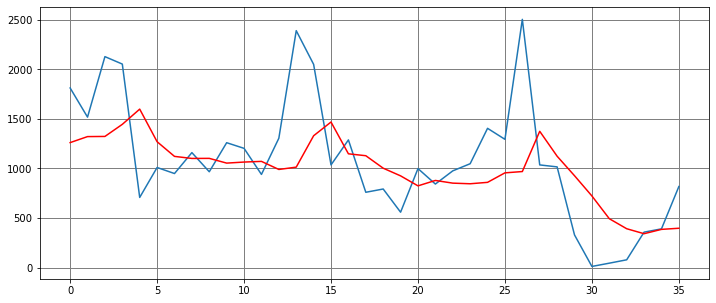

In [49]:
X = serieVendas.values
tamanho = int(len(X) * 0.66)
train, test = X[0:tamanho], X[tamanho:]
historico = [x for x in train]
predicoes = list()
for t in range(len(test)):
    model = ARIMA(historico, order=(2,2,2))
    model_fit = model.fit(disp=0)
    saida = model_fit.forecast()
    aux = saida[0]
    predicoes.append(aux)
    aux2 = test[t]
    historico.append(aux2)
    print('previsto = %f, esperado = %f' % (aux, aux2))
erro = np.sqrt(mean_squared_error(test, predicoes))
print('Teste RMSE: %.3f' % erro)

# plot
plt.figure(figsize=(12,5))

plt.grid(color='grey', linestyle='-', linewidth=1)
plt.plot(test)
plt.plot(predicoes, color='red')

O modelo considerou o melhor modelo com os parametros p =2 ,d =2 e q =2 . o RMSE foi o mais baixo, porem visualmente o 5,1,0 ficou mais similar, apesar do erro de 30 pontos para mais.

### conclusões

A modelagem ARIMA é relativamente simples de ser feita e testada, e para series temporais realmente é muito facil ver o resultado do modelo estatistico.

O tipo de caso estudado, vendas reais de uma empresa, deve levar muitos fatores em consideração que o modelo nao pode prever, como variaçoes na economia, lançamentos de produtos, esforços de venda , promocoes etc. 

